In [ ]:
import dolfin as dl
import ufl
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import sys
import os
sys.path.append( os.environ.get('HIPPYLIB_BASE_DIR', "../") )
sys.path.append("../../../")
sys.path.append("../")
from hippylib import *

sys.path.append( os.environ.get('HIPPYLIB_BASE_DIR', "..") + "/applications/ad_diff/" )
from model_ad_diff import TimeDependentAD, SpaceTimePointwiseStateObservation

import logging
logging.getLogger('FFC').setLevel(logging.WARNING)
logging.getLogger('UFL').setLevel(logging.WARNING)
dl.set_log_active(False)

In [75]:
import numpy as np

def fourier_scalar(t, cossin_coeffs, omegas):
    """
    cossin_coeffs: array shape (Nf, 2) where [:,0]=cos coeffs, [:,1]=sin coeffs
    returns sum_j a_j cos(ω_j t) + b_j sin(ω_j t)
    """
    val = 0.0
    for j in range(len(omegas)):
        a = cossin_coeffs[j, 0]
        b = cossin_coeffs[j, 1]
        w = omegas[j]
        val += a * np.cos(w*t) + b * np.sin(w*t)
    return val

def sigmoid(z):
    return 1.0 / (1.0 + np.exp(-z))

def unicycle_fourier_controls(t, omegas, coeffs_v, coeffs_w, v0=0.15, w0=0.0):
    """
    v(t) = v0 + Fourier(t; coeffs_v)
    ω(t) = w0 + Fourier(t; coeffs_w)
    """
    v = v0 + fourier_scalar(t, coeffs_v, omegas)
    w = w0 + fourier_scalar(t, coeffs_w, omegas)
    return v, w

def integrate_unicycle_path(times, x0, theta0, omegas, coeffs_v, coeffs_w,
                            v0=0.15, w0=0.0, eps=1e-3, substeps=10):
    """
    Option B: Integrate unicycle dynamics with Fourier controls.
    Returns positions c(t_n) mapped smoothly into (eps, 1-eps)^2.
    """
    x = np.array(x0, dtype=float)
    theta = float(theta0)
    pts = []

    for i in range(len(times)):
        if i == 0:
            # record initial
            raw = x.copy()
        else:
            t0, t1 = times[i-1], times[i]
            h = (t1 - t0) / substeps
            t = t0
            for _ in range(substeps):
                v, w = unicycle_fourier_controls(t, omegas, coeffs_v, coeffs_w, v0=v0, w0=w0)

                # optional: keep v nonnegative smoothly (so you don't go backwards unintentionally)
                v = 1e-6 + np.log1p(np.exp(v))  # softplus

                # integrate
                x[0] += h * v * np.cos(theta)
                x[1] += h * v * np.sin(theta)
                theta += h * w
                t += h

            raw = x.copy()

        # smooth feasibility map
        mapped = eps + (1.0 - 2.0*eps) * sigmoid(raw)
        pts.append(mapped)

    return np.array(pts)


In [76]:
def v_boundary(x, on_boundary):
    return on_boundary

def q_boundary(x, on_boundary):
    return x[0] < dl.DOLFIN_EPS and x[1] < dl.DOLFIN_EPS

def computeVelocityField(mesh):
    Xh = dl.VectorFunctionSpace(mesh, 'Lagrange', 2)
    Wh = dl.FunctionSpace(mesh, 'Lagrange', 1)
    mixed_element = ufl.MixedElement([Xh.ufl_element(), Wh.ufl_element()])
    XW = dl.FunctionSpace(mesh, mixed_element)

    Re = dl.Constant(100.0)

    g = dl.Expression(('4.0*x[1]*(1.0-x[1])', '0.0'), degree=2)
    
    bc1 = dl.DirichletBC(XW.sub(0), g, "near(x[0], 0.0)")
    bc2 = dl.DirichletBC(XW.sub(0), dl.Constant((0.0, 0.0)), "near(x[1], 0.0) || near(x[1], 1.0)")
    bc3 = dl.DirichletBC(XW.sub(1), dl.Constant(0), q_boundary, 'pointwise')
    
    bcs = [bc1, bc2, bc3]

    vq = dl.Function(XW)
    (v, q) = ufl.split(vq)
    (v_test, q_test) = dl.TestFunctions(XW)

    def strain(v):
        return ufl.sym(ufl.grad(v))

    F = ( (2./Re)*ufl.inner(strain(v), strain(v_test)) 
          + ufl.inner(ufl.nabla_grad(v)*v, v_test)
          - (q * ufl.div(v_test)) 
          + (ufl.div(v) * q_test) ) * ufl.dx

    dl.solve(F == 0, vq, bcs, solver_parameters={"newton_solver":
                                         {"relative_tolerance":1e-4, "maximum_iterations":100}})

    vh = dl.project(v, Xh)
    qh = dl.project(q, Wh)
    
    plt.figure(figsize=(15, 5))
    
    mesh_coarse = dl.UnitSquareMesh(16, 16)
    vh_coarse = dl.interpolate(vh, dl.VectorFunctionSpace(mesh_coarse, "CG", 1))
    
    nb.plot(vh_coarse, subplot_loc=121, mytitle="Velocity (Parabolic)")
    nb.plot(qh, subplot_loc=122, mytitle="Pressure")
    plt.show()

    return vh


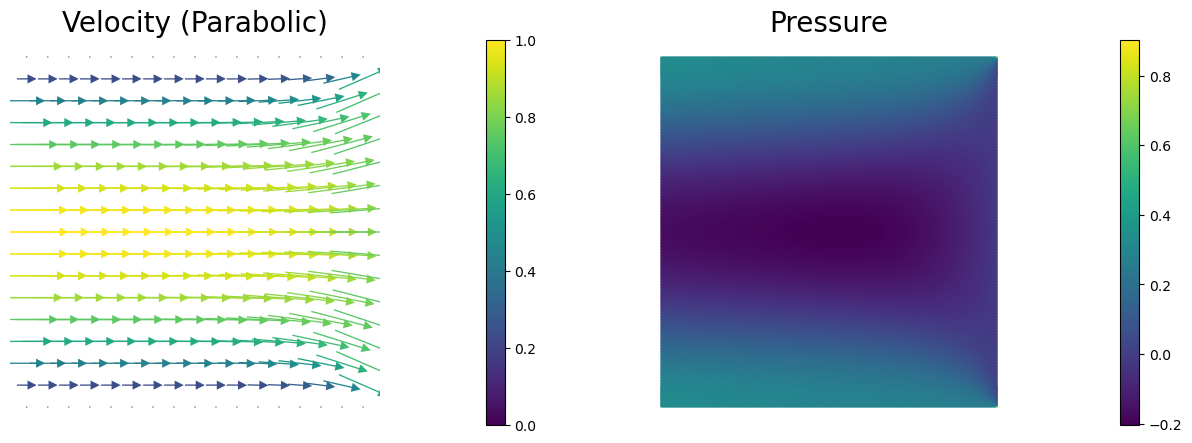

Number of dofs: 21103


In [77]:
nx, ny = 60, 120
mesh = dl.UnitSquareMesh(nx, ny)

for _ in range(2):  
    markers = dl.MeshFunction("bool", mesh, mesh.topology().dim())
    markers.set_all(False)

    for cell in dl.cells(mesh):
        y = cell.midpoint().y()
        if y < 0.06 or y > 0.94:     
            markers[cell] = True

    mesh = dl.refine(mesh, markers)

wind_velocity = computeVelocityField(mesh)
Vh = dl.FunctionSpace(mesh, "Lagrange", 1)
print("Number of dofs: {0}".format(Vh.dim()))

In [78]:
targets_content = """\
0.25 0.149
0.275 0.149
0.30 0.149
0.325 0.149
0.35 0.149
0.375 0.149
0.40 0.149
0.425 0.149
0.45 0.149
0.475 0.149
0.50 0.149
0.25 0.401
0.275 0.401
0.30 0.401
0.325 0.401
0.35 0.401
0.375 0.401
0.40 0.401
0.425 0.401
0.45 0.401
0.475 0.401
0.50 0.401
0.249 0.15
0.249 0.175
0.249 0.20
0.249 0.225
0.249 0.25
0.249 0.275
0.249 0.30
0.249 0.325
0.249 0.35
0.249 0.375
0.249 0.40
0.501 0.15
0.501 0.175
0.501 0.20
0.501 0.225
0.501 0.25
0.501 0.275
0.501 0.30
0.501 0.325
0.501 0.35
0.501 0.375
0.501 0.40
0.60 0.599
0.625 0.599
0.65 0.599
0.675 0.599
0.70 0.599
0.725 0.599
0.75 0.599
0.60 0.851
0.625 0.851
0.65 0.851
0.675 0.851
0.70 0.851
0.725 0.851
0.75 0.851
0.599 0.6
0.599 0.625
0.599 0.65
0.599 0.675
0.599 0.70
0.599 0.725
0.599 0.75
0.599 0.775
0.599 0.80
0.599 0.825
0.599 0.85
0.751 0.6
0.751 0.625
0.751 0.65
0.751 0.675
0.751 0.70
0.751 0.725
0.751 0.75
0.751 0.775
0.751 0.80
0.751 0.825
0.751 0.85
"""

with open('targets.txt', 'w') as f:
    f.write(targets_content)
targets = np.loadtxt('targets.txt')
print("Number of observation points:", targets.shape[0])

Number of observation points: 80


Number of observation points: 16


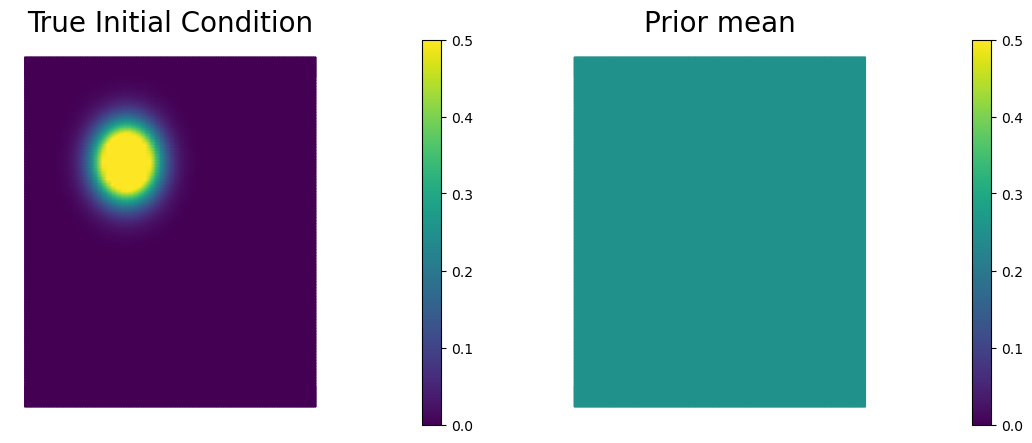

In [79]:
ic_expr = dl.Expression(
    'std::min(0.5, std::exp(-100*(std::pow(x[0]-0.35,2) + std::pow(x[1]-0.7,2))))',
    element=Vh.ufl_element()
)
true_initial_condition = dl.interpolate(ic_expr, Vh).vector()

gamma = 1.
delta = 8.
prior = BiLaplacianPrior(Vh, gamma, delta, robin_bc=True)
prior.mean = dl.interpolate(dl.Constant(0.25), Vh).vector()

t_init = 0.
t_final = 4.
t_1 = 1.
dt = .1
observation_dt = .2

simulation_times = np.arange(t_init, t_final + .5*dt, dt)
observation_times = np.arange(t_1, t_final + .5*dt, observation_dt)

Ty = (t_1, t_final)
Nf = 3
omegas = fourier_frequencies(Ty, Nf)
coeffs_v = np.array([
    [ 0.05,  0.00],
    [ 0.02,  0.01],
    [ 0.01, -0.01],
], dtype=float)

coeffs_w = np.array([
    [ 0.00,  0.10],
    [ 0.00,  0.05],
    [ 0.00, -0.02],
], dtype=float)

x0 = np.array([0.35, 0.70], dtype=float)  
theta0 = 0.0                              

targets = integrate_unicycle_path(
    observation_times,
    x0=x0,
    theta0=theta0,
    omegas=omegas,
    coeffs_v=coeffs_v,
    coeffs_w=coeffs_w,
    v0=0.15,
    w0=0.0,
    eps=1e-3,
    substeps=20
)

print("Number of observation points:", targets.shape[0])
assert targets.shape[0] == len(observation_times)

misfit = SpaceTimePointwiseStateObservation(Vh, observation_times, targets)



problem = TimeDependentAD(mesh, [Vh, Vh, Vh], prior, misfit, simulation_times, wind_velocity, True)

objs = [
    dl.Function(Vh, true_initial_condition),
    dl.Function(Vh, prior.mean)
]
mytitles = ["True Initial Condition", "Prior mean"]
nb.multi1_plot(objs, mytitles)
plt.show()

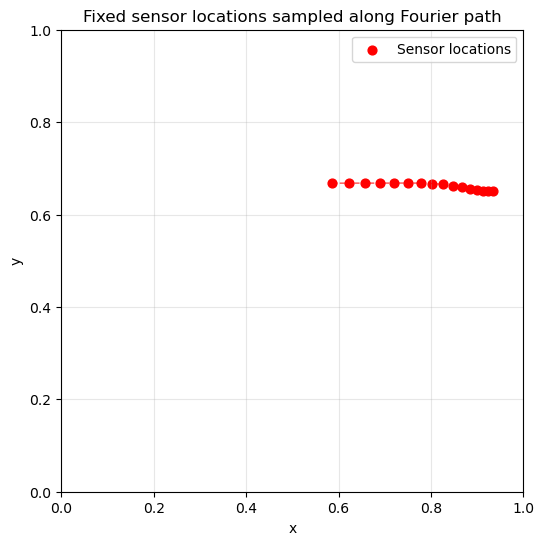

In [80]:
plt.figure(figsize=(6, 6))

plt.scatter(targets[:, 0], targets[:, 1],
            c='red', s=40, label='Sensor locations')

plt.plot(targets[:, 0], targets[:, 1],
         'r--', linewidth=1, alpha=0.7)
plt.xlim(0.0, 1.0)
plt.ylim(0.0, 1.0)
plt.gca().set_aspect('equal', 'box')
plt.grid(True, alpha=0.3)

plt.xlabel('x')
plt.ylabel('y')
plt.title('Fixed sensor locations sampled along Fourier path')
plt.legend()
plt.show()


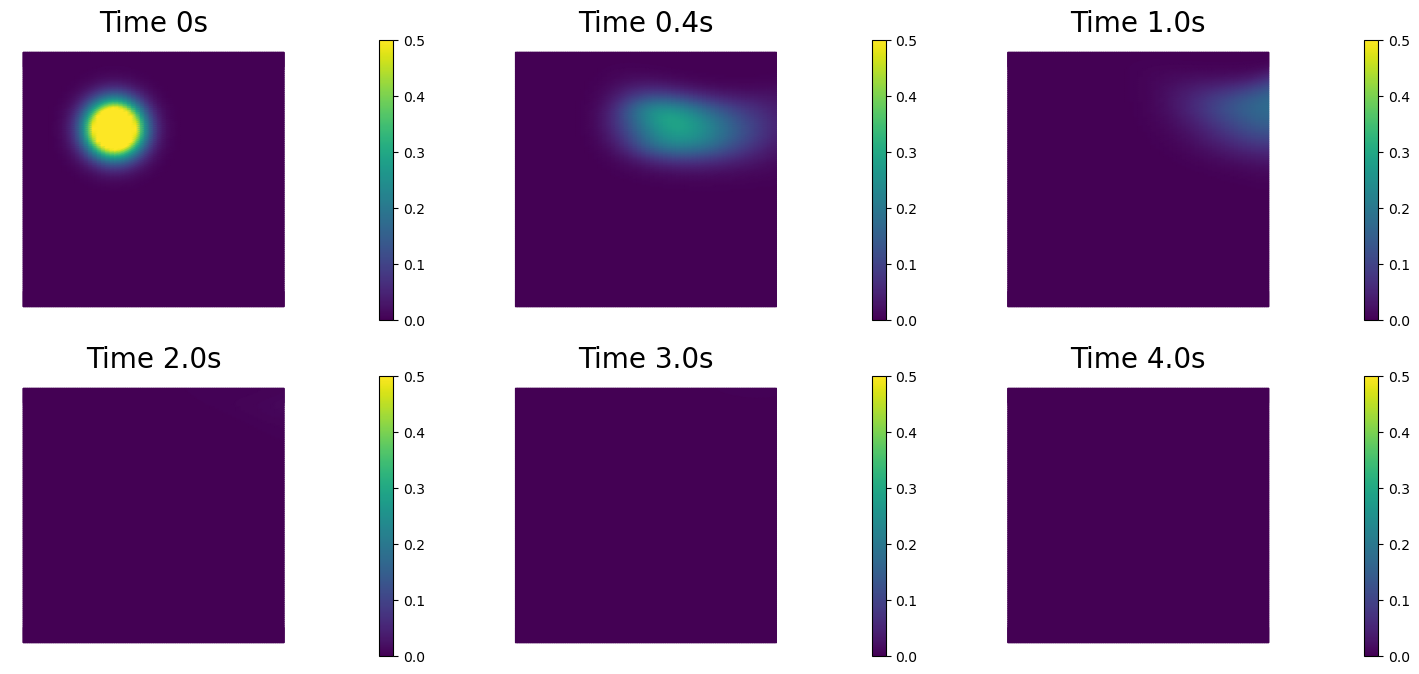

In [81]:
rel_noise = 0.01
utrue = problem.generate_vector(STATE)
x = [utrue, true_initial_condition, None]
problem.solveFwd(x[STATE], x)
misfit.observe(x, misfit.d)
MAX = misfit.d.norm("linf", "linf")
noise_std_dev = rel_noise * MAX
parRandom.normal_perturb(noise_std_dev, misfit.d)
misfit.noise_variance = noise_std_dev * noise_std_dev
nb.show_solution(Vh, true_initial_condition, utrue, "Solution (True + Noisy Observations)")


(yy, H xx) - (xx, H yy) =  -4.103457708339733e-12


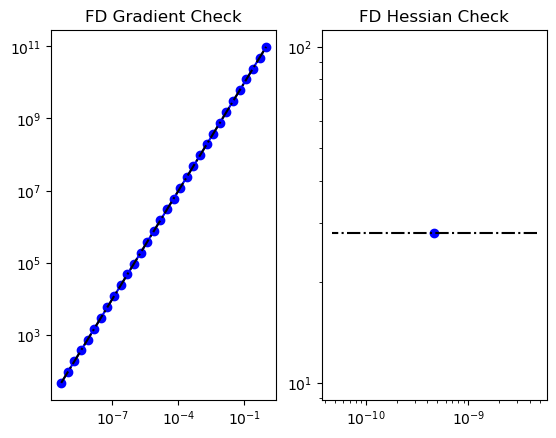

In [26]:
m0 = true_initial_condition.copy()
_ = modelVerify(problem, m0, is_quadratic=True)

In [27]:
[u, m, p] = problem.generate_vector()

# (Optional) make it explicit like Code A usually implies:
# m.zero()

problem.solveFwd(u, [u, m, p])
problem.solveAdj(p, [u, m, p])

mg = problem.generate_vector(PARAMETER)
grad_norm = problem.evalGradientParameter([u, m, p], mg)

print("(g,g) = ", grad_norm)


(g,g) =  5.886307016726993e+17


Single Pass Algorithm. Requested eigenvectors: 80; Oversampling 20.


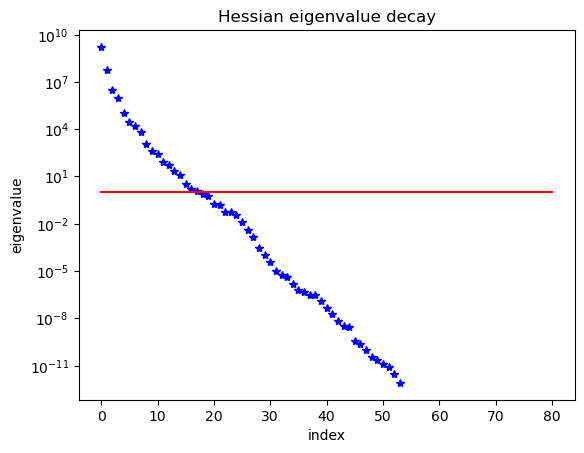

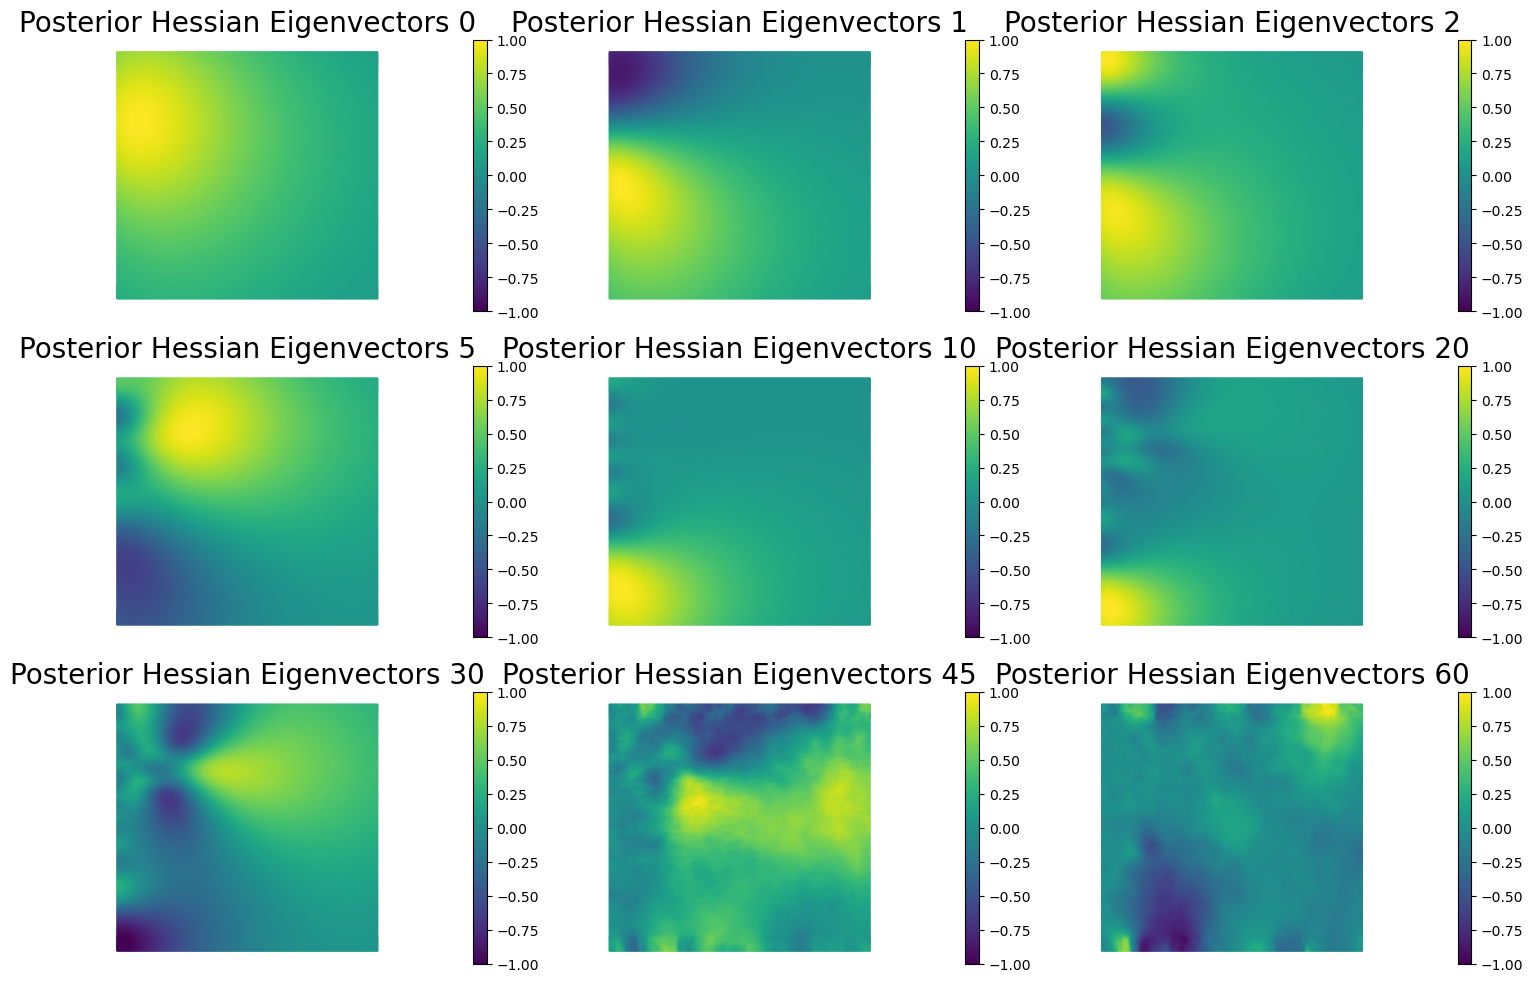

In [28]:
u_lin = problem.generate_vector(STATE)
x_lin = [u_lin, m, None]

problem.solveFwd(x_lin[STATE], x_lin)

H = ReducedHessian(problem, misfit_only=True)

k = 80
p = 20
print("Single Pass Algorithm. Requested eigenvectors: {0}; Oversampling {1}."
      .format(k, p))

Omega = MultiVector(x_lin[PARAMETER], k + p)
parRandom.normal(1.0, Omega)

lmbda, V = singlePassG(H, prior.R, prior.Rsolver, Omega, k)

posterior = GaussianLRPosterior(prior, lmbda, V)

plt.figure()
plt.plot(range(k), lmbda, 'b*', range(k+1), np.ones(k+1), '-r')
plt.yscale('log')
plt.xlabel('index')
plt.ylabel('eigenvalue')
plt.title('Hessian eigenvalue decay')
plt.show()

nb.plot_eigenvectors(
    Vh, V,
    mytitle="Posterior Hessian Eigenvectors",
    which=[0, 1, 2, 5, 10, 20, 30, 45, 60]
)
plt.show()


 Iterartion :  0  (B r, r) =  27934.207741103895
 Iteration :  1  (B r, r) =  20.00480289696874
 Iteration :  2  (B r, r) =  0.3203199526259057
 Iteration :  3  (B r, r) =  0.0007849585716099966
 Iteration :  4  (B r, r) =  3.114444839809886e-06
 Iteration :  5  (B r, r) =  6.74838969343139e-10
Relative/Absolute residual less than tol
Converged in  5  iterations with final norm  2.597766289224531e-05
Total cost 259.444; Reg Cost 19.6892; Misfit 239.755


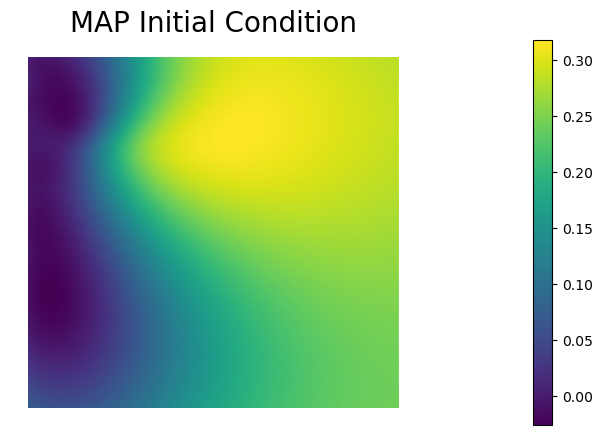

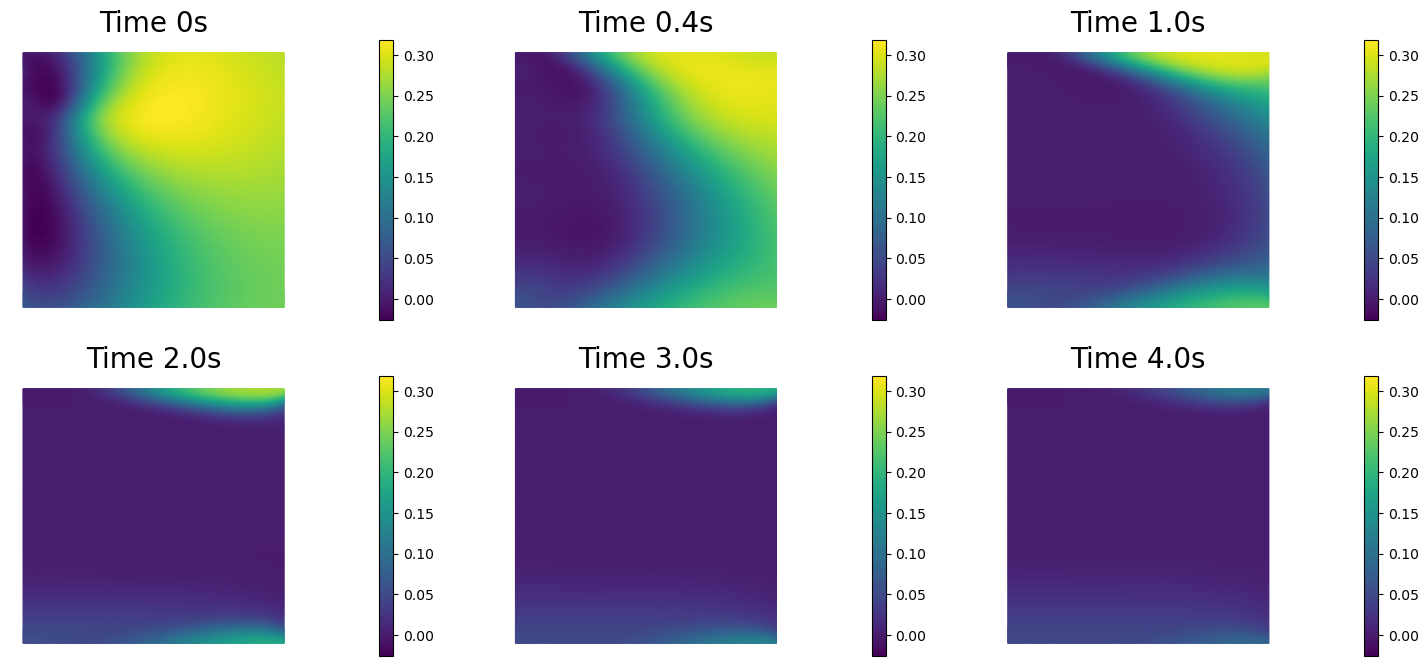

In [29]:
H.misfit_only = False

solver = CGSolverSteihaug()
solver.set_operator(H)
solver.set_preconditioner(posterior.Hlr)

solver.parameters["print_level"] = 1
solver.parameters["rel_tolerance"] = 1e-6

solver.solve(m, -mg)
try:
    u
    p
except NameError:
    u = problem.generate_vector(STATE)
    p = problem.generate_vector(ADJOINT)

problem.solveFwd(u, [u, m, p])
total_cost, reg_cost, misfit_cost = problem.cost([u, m, p])
print("Total cost {0:5g}; Reg Cost {1:5g}; Misfit {2:5g}".format(total_cost, reg_cost, misfit_cost))

posterior.mean = m

plt.figure(figsize=(7.5, 5))
nb.plot(dl.Function(Vh, m), mytitle="MAP Initial Condition")
plt.show()

nb.show_solution(Vh, m, u, "Solution at MAP")
plt.show()


Posterior trace 0.00547764; Prior trace 0.0104281; Correction trace 0.0049505


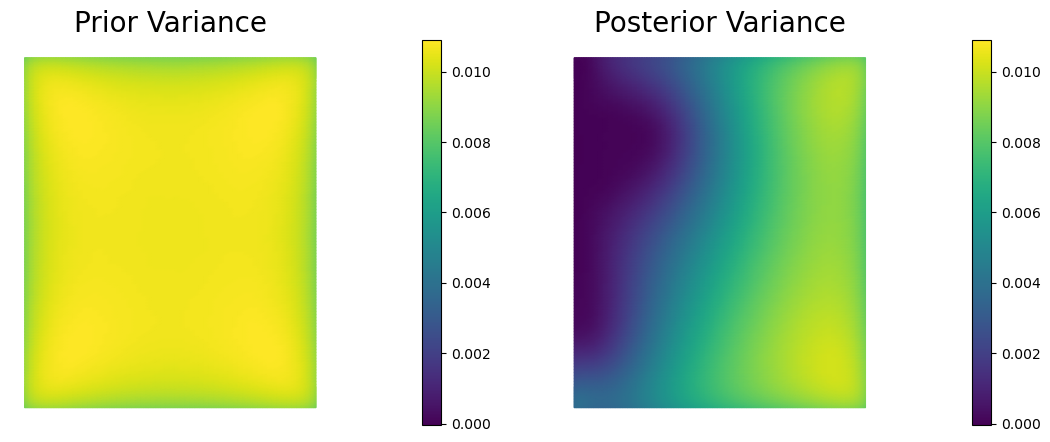

In [30]:
compute_trace = True
if compute_trace:
    post_tr, prior_tr, corr_tr = posterior.trace(method="Randomized", r=300)
    print( "Posterior trace {0:5g}; Prior trace {1:5g}; Correction trace {2:5g}".format(post_tr, prior_tr, corr_tr) )
post_pw_variance, pr_pw_variance, corr_pw_variance = posterior.pointwise_variance(method="Randomized", r=300)

objs = [dl.Function(Vh, pr_pw_variance),
        dl.Function(Vh, post_pw_variance)]
mytitles = ["Prior Variance", "Posterior Variance"]
nb.multi1_plot(objs, mytitles, logscale=False)
plt.show()


In [30]:
def compute_EIG_for_c(c_mask, r=20, oversampling=10):
    """
    Computes EIG(c) = sum_{i=1}^r log(1 + lambda_i)

    Control c enters ONLY through B(c), implemented by selecting targets.
    """

    # ----------------------------
    # Build B(c) via target selection
    # ----------------------------
    targets_c = targets_all[c_mask]

    misfit_c = SpaceTimePointwiseStateObservation(
        Vh, observation_times, targets_c
    )

    # ----------------------------
    # IMPORTANT FIX:
    # ReducedHessian requires noise_variance != None
    # ----------------------------
    rel_noise = 0.01
    misfit_c.noise_variance = rel_noise ** 2

    # ----------------------------
    # Build inverse problem (unchanged)
    # ----------------------------
    problem_c = TimeDependentAD(
        mesh, [Vh, Vh, Vh],
        prior, misfit_c,
        simulation_times,
        wind_velocity,
        True
    )

    # ----------------------------
    # Reduced Hessian (misfit only)
    # ----------------------------
    H = ReducedHessian(problem_c, misfit_only=True)

    k = r
    p = oversampling

    # Randomized eigensolver setup
    m_template = problem_c.generate_vector(PARAMETER)
    Omega = MultiVector(m_template, k + p)
    parRandom.normal(1.0, Omega)

    # Generalized eigenpairs
    lmbda, V = singlePassG(
        H, prior.R, prior.Rsolver, Omega, k
    )

    # ----------------------------
    # Expected Information Gain
    # ----------------------------
    EIG = float(np.sum(np.log(1.0 + np.array(lmbda))))

    return EIG, lmbda, V


In [31]:
# =========================
# EIG evaluation for a test control c
# =========================

# Example control c: activate the first 30 sensors
N = targets_all.shape[0]
c_mask = np.zeros(N, dtype=bool)
c_mask[:30] = True

EIG_value, lmbda, V = compute_EIG_for_c(c_mask, r=20, oversampling=10)
print("EIG(c) =", EIG_value)


EIG(c) = 29.125145351857814


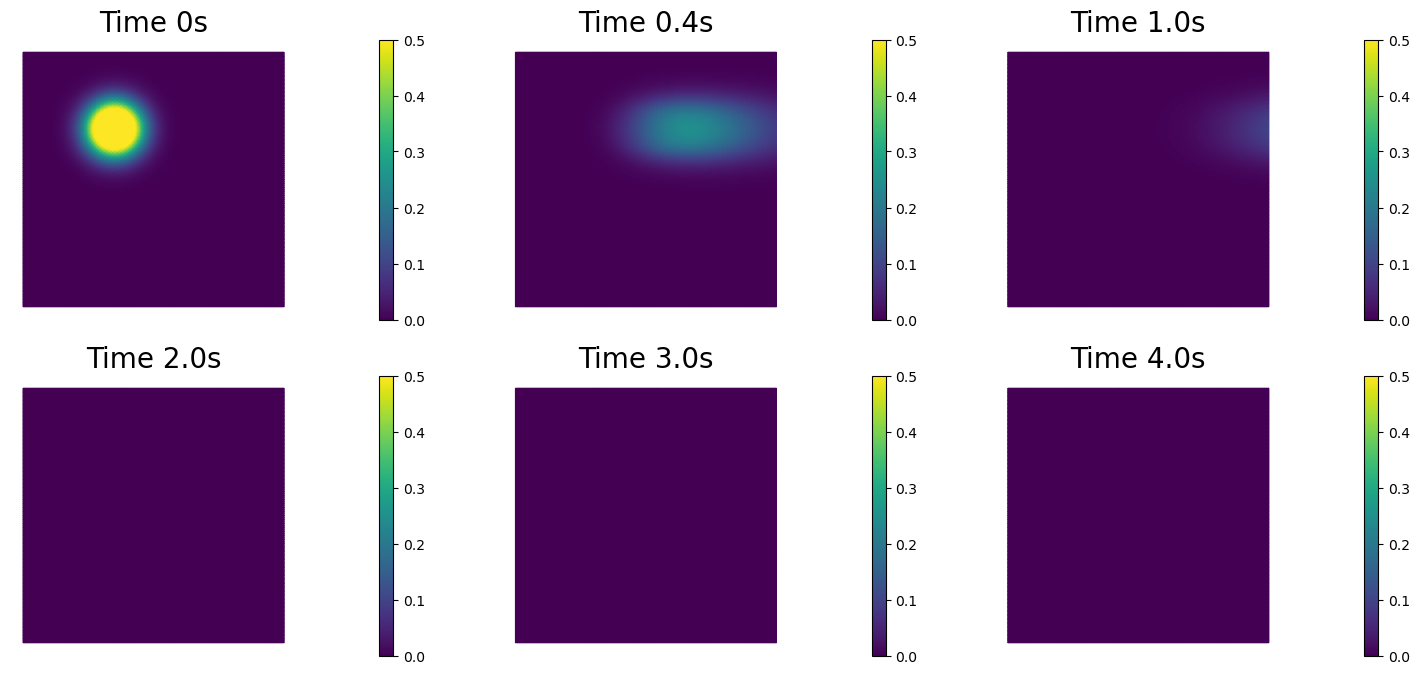

In [32]:
rel_noise = 0.01
utrue = problem.generate_vector(STATE)
x = [utrue, true_initial_condition, None]
problem.solveFwd(x[STATE], x)
misfit.observe(x, misfit.d)
MAX = misfit.d.norm("linf", "linf")
noise_std_dev = rel_noise * MAX
parRandom.normal_perturb(noise_std_dev,misfit.d)
misfit.noise_variance = noise_std_dev*noise_std_dev

nb.show_solution(Vh, true_initial_condition, utrue, "Solution")

(yy, H xx) - (xx, H yy) =  7.395724080638204e-14


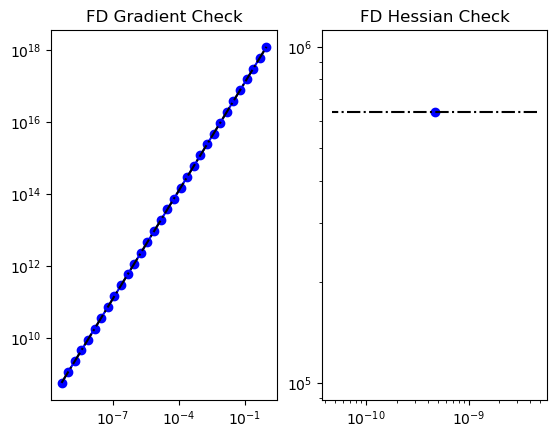

In [33]:
m0 = true_initial_condition.copy()
_ = modelVerify(problem, m0, is_quadratic=True)

In [34]:
[u,m,p] = problem.generate_vector()
problem.solveFwd(u, [u,m,p])
problem.solveAdj(p, [u,m,p])
mg = problem.generate_vector(PARAMETER)
grad_norm = problem.evalGradientParameter([u,m,p], mg)

print( "(g,g) = ", grad_norm)

(g,g) =  2.143433499867579e+28


Single Pass Algorithm. Requested eigenvectors: 80; Oversampling 20.


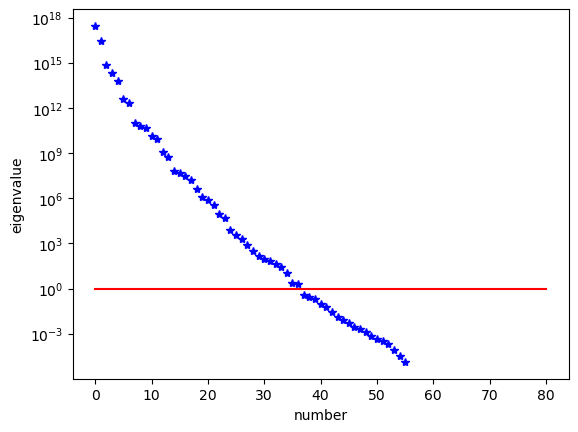

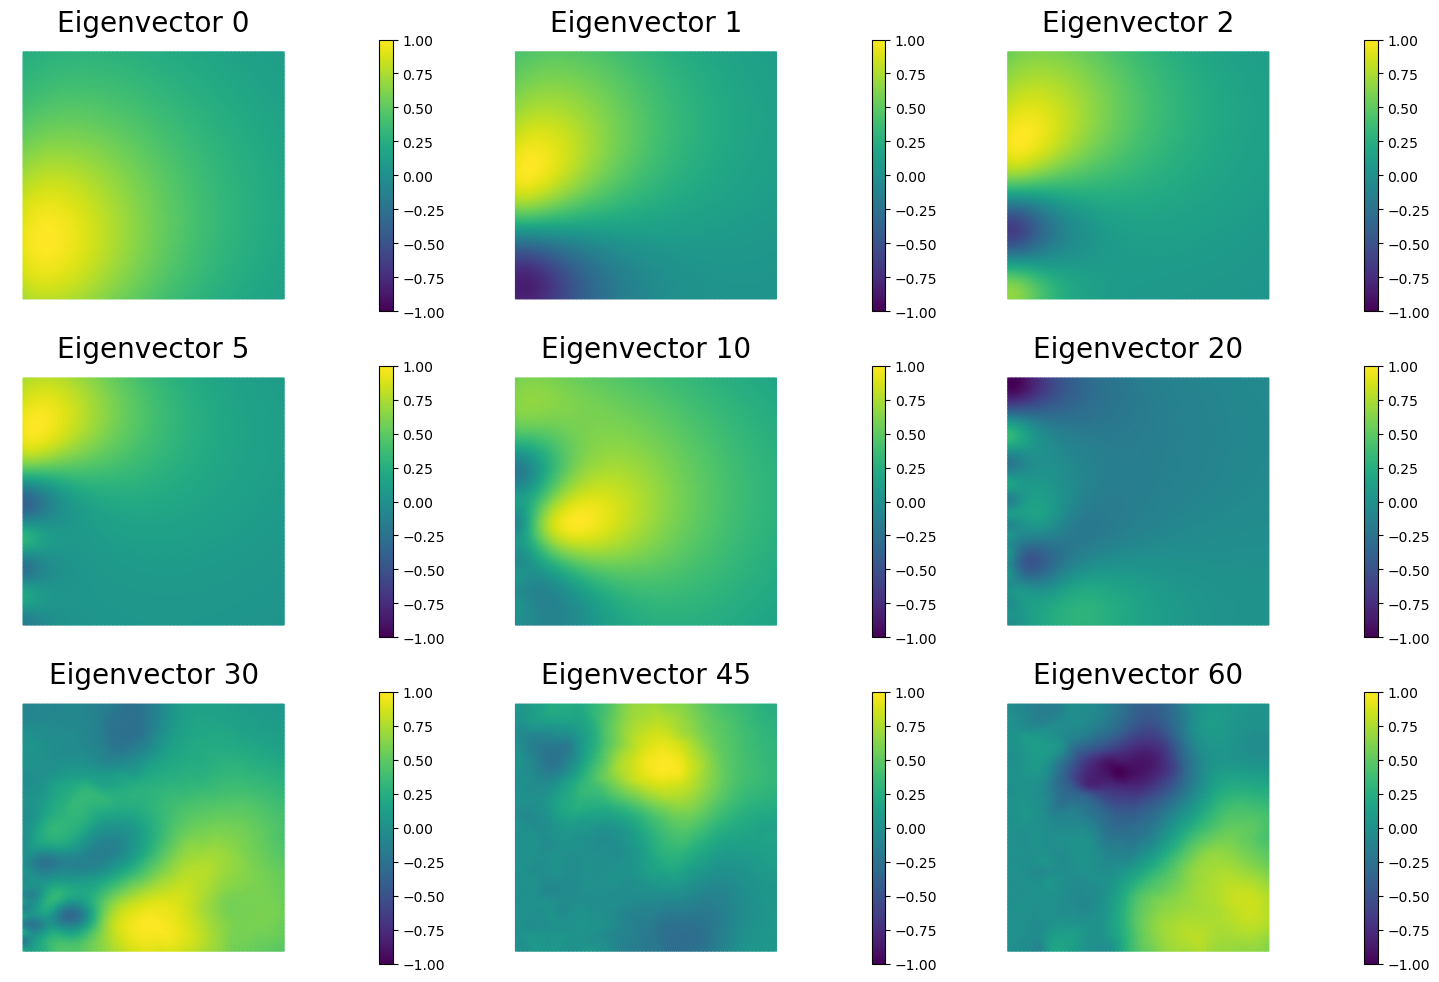

In [35]:
H = ReducedHessian(problem, misfit_only=True) 

k = 80
p = 20
print( "Single Pass Algorithm. Requested eigenvectors: {0}; Oversampling {1}.".format(k,p) )
Omega = MultiVector(x[PARAMETER], k+p)
parRandom.normal(1., Omega)
lmbda, V = singlePassG(H, prior.R, prior.Rsolver, Omega, k)


posterior = GaussianLRPosterior( prior, lmbda, V )

plt.plot(range(0,k), lmbda, 'b*', range(0,k+1), np.ones(k+1), '-r')
plt.yscale('log')
plt.xlabel('number')
plt.ylabel('eigenvalue')

nb.plot_eigenvectors(Vh, V, mytitle="Eigenvector", which=[0,1,2,5,10,20,30,45,60])

 Iterartion :  0  (B r, r) =  6.935856582675044e+35
 Iteration :  1  (B r, r) =  5.1356174933861245e+31
 Iteration :  2  (B r, r) =  6.215785837106292e+29
 Iteration :  3  (B r, r) =  6.494833870372743e+27
 Iteration :  4  (B r, r) =  1.2460816935532948e+27
 Iteration :  5  (B r, r) =  1.8561741387511884e+27
 Iteration :  6  (B r, r) =  3.2655330389248957e+24
 Iteration :  7  (B r, r) =  1.1080111883041346e+25
 Iteration :  8  (B r, r) =  3.959861686270055e+23
Relative/Absolute residual less than tol
Converged in  8  iterations with final norm  629274319058.8708
Total cost 3.29854e+18; Reg Cost 1.19295e+07; Misfit 3.29854e+18


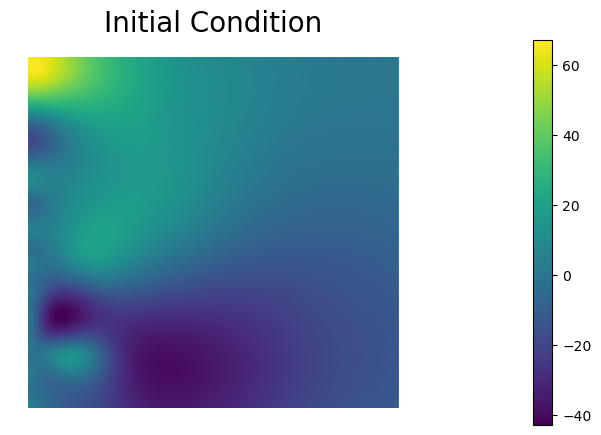

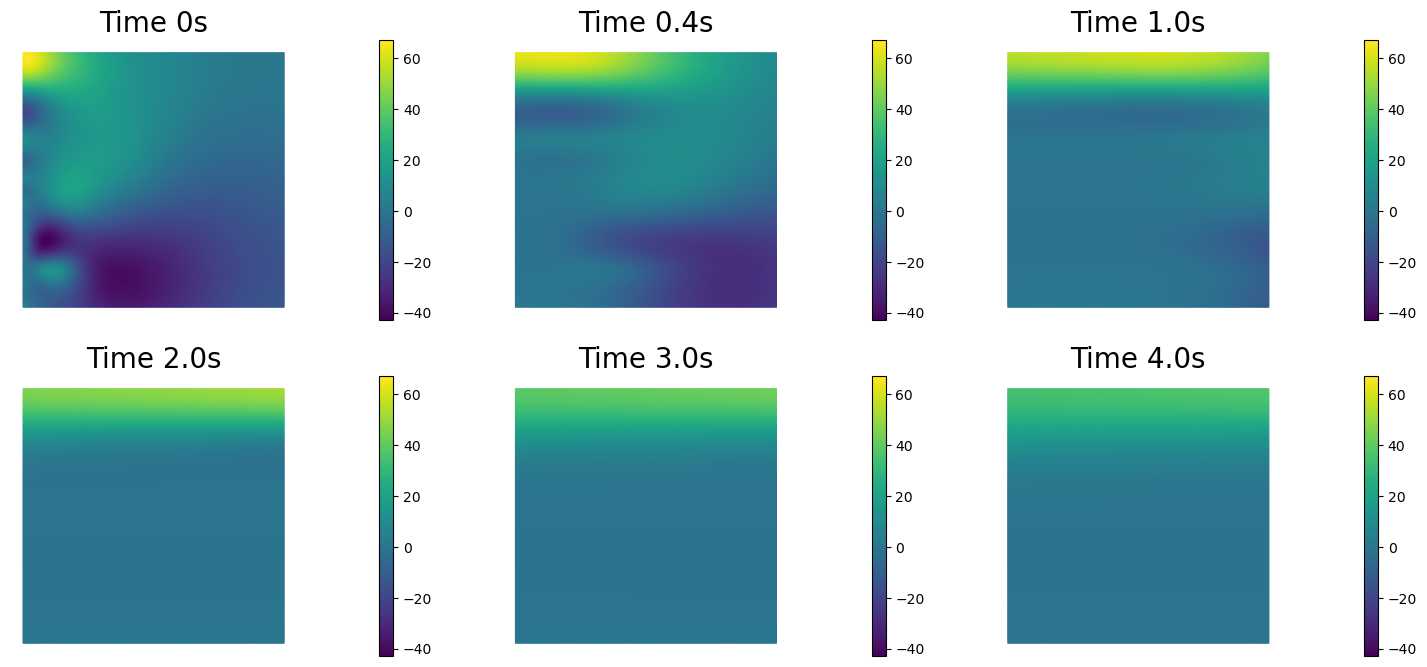

In [42]:
# -------------------------
# Fixed Newton/CG step
# -------------------------

# Use full Hessian
H.misfit_only = False

# Build RHS = -mg robustly (avoid "-mg")
rhs = mg.copy()
rhs *= -1.0

# Solve for increment dm: H dm = -g
solver = CGSolverSteihaug()
solver.set_operator(H)

# IMPORTANT: use SPD preconditioner (guaranteed) to avoid math-domain errors
solver.set_preconditioner(prior.Rsolver)


solver.parameters["print_level"] = 1
solver.parameters["rel_tolerance"] = 1e-6

dm = problem.generate_vector(PARAMETER)
dm.zero()

solver.solve(dm, rhs)

# Update parameter: m <- m + dm
m.axpy(1.0, dm)

# Forward solve at updated parameter
problem.solveFwd(u, [u, m, p])

# Costs
total_cost, reg_cost, misfit_cost = problem.cost([u, m, p])
print("Total cost {0:5g}; Reg Cost {1:5g}; Misfit {2:5g}".format(total_cost, reg_cost, misfit_cost))

# Store posterior mean safely
posterior.mean = m.copy()

# Robust plot (Vector -> Function)
m_fun = dl.Function(Vh)
m_fun.vector().zero()
m_fun.vector().axpy(1.0, m)

plt.figure(figsize=(7.5, 5))
nb.plot(m_fun, mytitle="Initial Condition")
plt.show()

nb.show_solution(Vh, m, u, "Solution")


Posterior trace 0.00509314; Prior trace 0.0104364; Correction trace 0.00534328


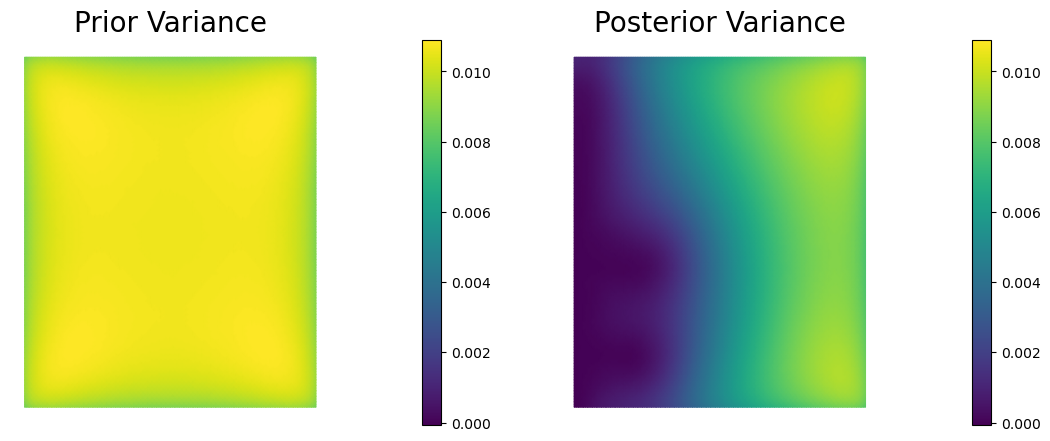

In [43]:
compute_trace = True
if compute_trace:
    post_tr, prior_tr, corr_tr = posterior.trace(method="Randomized", r=300)
    print( "Posterior trace {0:5g}; Prior trace {1:5g}; Correction trace {2:5g}".format(post_tr, prior_tr, corr_tr) )
post_pw_variance, pr_pw_variance, corr_pw_variance = posterior.pointwise_variance(method="Randomized", r=300)

objs = [dl.Function(Vh, pr_pw_variance),
        dl.Function(Vh, post_pw_variance)]
mytitles = ["Prior Variance", "Posterior Variance"]
nb.multi1_plot(objs, mytitles, logscale=False)
plt.show()